# Проект по классификации текста

### На входе будет набор текстовых отзывов о фильмах, размеченных как положительные и отрицательные (позитивные и негативные).

Более подробно об этих данных можно почитать здесь: http://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../DATA/moviereviews.csv')

In [6]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


**Проверим, есть ли какие-либо отсутствующие значения в этих данных.**

In [8]:
df.isnull().sum()

label      0
review    35
dtype: int64

**Удалим отзывы о фильмах, текст которых принимает значение NaN**

In [10]:
df = df.dropna()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1965 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1965 non-null   object
 1   review  1965 non-null   object
dtypes: object(2)
memory usage: 46.1+ KB


**Проверим, есть ли какие-то отзывы с пустым текстом, но отличающимся от значения NaN. То есть, текст может быть таким: "" или "  " или какая-то другая строка из нескольких пробелов. Это можно сделать разными способами. После того как найдём такие отзывы, удалим их из датафрейма. [В качестве подсказки можно использовать эту ссылку.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.isspace.html)**

In [14]:
df['review'].str.isspace().sum()

np.int64(27)

In [16]:
df[df['review'].str.isspace()]

,label,review
57,neg,
71,pos,
147,pos,
151,pos,
283,pos,
307,pos,
313,neg,
323,pos,
343,pos,
351,neg,


In [61]:
# Также проверим есть ли пустые строки не из пробелов
df['review'].apply(lambda review:review=="").sum()

np.int64(0)

In [59]:
df[df['review'].apply(lambda review:review=="")]

,label,review


In [18]:
# Возьмём все строки, которые не являются пробелами
# Знак ~ меняет условие на противоположное
df = df[~df['review'].str.isspace()]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1938 non-null   object
 1   review  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


**Посчитаем количество строк для различных значений колонки label:**

In [22]:
df['label'].value_counts()

label
neg    969
pos    969
Name: count, dtype: int64

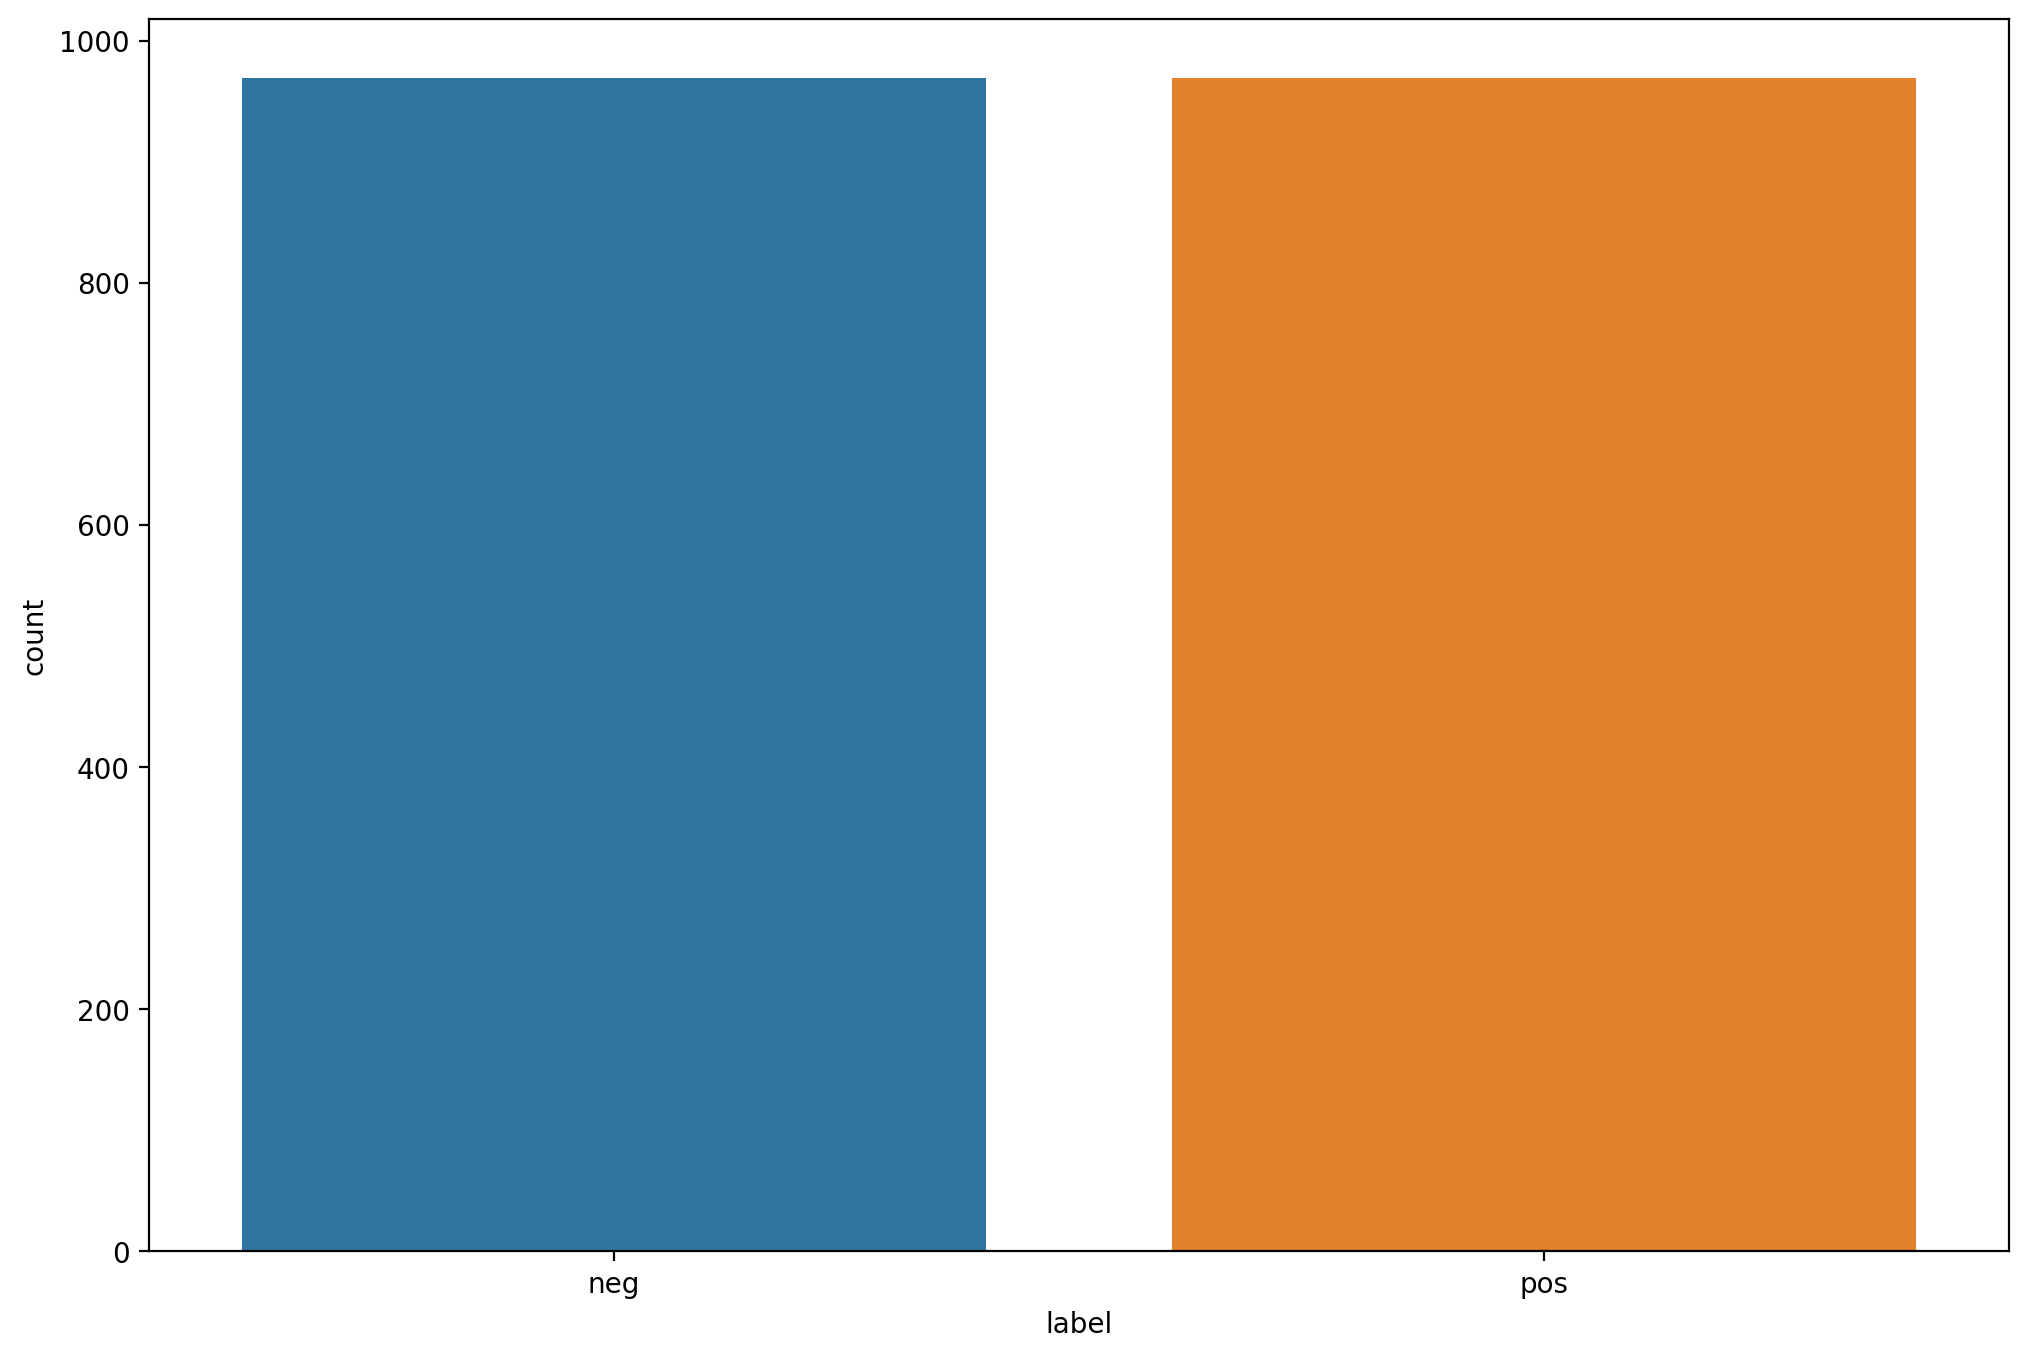

In [24]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='label', hue='label')
plt.show()

## Исследование данных (EDA) для мешка слов (bag of words)

**С помощью модели CountVectorizer найдём 20 наиболее часто встречающихся слов (которые не являются стоп-словами в английском языке), отдельно для каждого значения колонки label. [В качестве подсказки можете использовать эту ссылку.](https://stackoverflow.com/questions/16288497/find-the-most-common-term-in-scikit-learn-classifier)**

In [26]:
df_neg = df[df['label']=='neg']
df_neg.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
4,neg,my first press screening of 1998 and already i...
5,neg,"to put it bluntly , ed wood would have been pr..."
6,neg,"synopsis : melissa , a mentally-disturbed woma..."


In [28]:
df_pos = df[df['label']=='pos']
df_pos.head()

,label,review
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
11,pos,"with stars like sigourney weaver ( "" alien "" t..."
16,pos,i remember hearing about this film when it fir...
18,pos,garry shandling makes his long overdue starrin...


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
def count_words(reviews, rev_type='neg'):
    '''
    Данная функция выводит 20 наиболее часто встречающихся слов 
    (которые не являются стоп-словами в английском языке).

    Параметр reviews - серия (Series) с текстовыми данными отзывов.
    
    Параметр `rev_type` - может принимать значения `neg` и `pos`, 
    по умолчанию `neg`. В зависимости от значения данного параметра 
    форматируется строка вывода.
    '''
    
    cv = CountVectorizer(stop_words='english')
    # Метод fit обучает CountVectorizer на данных 
    vec = cv.fit(reviews)
    # Преобразование текста из датафрейма в матрицу признаков
    bag_of_words = vec.transform(reviews)
    # Cуммируем количество встречающихся слов по всем отзывам
    sum_words = bag_of_words.sum(axis=0)
    
    # Создается список кортежей word_freq, где каждый кортеж содержит слово и его частоту. 
    # vec.vocabulary_ — это словарь, который сопоставляет слова с их индексами в матрице признаков
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    if rev_type == 'neg':
        # Здесь lambda используется для указания функции сортировки. В данном случае x представляет собой каждый 
        # элемент из word_freq, и мы сортируем по второму элементу кортежа (то есть по частоте слова). 
        # Это означает, что сортировка будет происходить на основе количества упоминаний слов.
        print(f'Top 20 words used for Negative reviews:\n{sorted(word_freq, key=lambda x:x[1], reverse=True)[:20]}')
    if rev_type == 'pos':
         print(f'Top 20 words used for Positive reviews:\n{sorted(word_freq, key=lambda x:x[1], reverse=True)[:20]}')

In [34]:
count_words(df_neg['review'])

Top 20 words used for Negative reviews:
[('film', np.int64(4063)), ('movie', np.int64(3131)), ('like', np.int64(1808)), ('just', np.int64(1480)), ('time', np.int64(1127)), ('good', np.int64(1117)), ('bad', np.int64(997)), ('character', np.int64(926)), ('story', np.int64(908)), ('plot', np.int64(888)), ('characters', np.int64(838)), ('make', np.int64(813)), ('really', np.int64(743)), ('way', np.int64(734)), ('little', np.int64(696)), ('don', np.int64(683)), ('does', np.int64(666)), ('doesn', np.int64(648)), ('action', np.int64(635)), ('scene', np.int64(634))]


In [36]:
count_words(df_pos['review'], rev_type='pos')

Top 20 words used for Positive reviews:
[('film', np.int64(5002)), ('movie', np.int64(2389)), ('like', np.int64(1721)), ('just', np.int64(1273)), ('story', np.int64(1199)), ('good', np.int64(1193)), ('time', np.int64(1175)), ('character', np.int64(1037)), ('life', np.int64(1032)), ('characters', np.int64(957)), ('way', np.int64(864)), ('films', np.int64(851)), ('does', np.int64(828)), ('best', np.int64(788)), ('people', np.int64(769)), ('make', np.int64(764)), ('little', np.int64(751)), ('really', np.int64(731)), ('man', np.int64(728)), ('new', np.int64(702))]


---

In [70]:
count_vect = CountVectorizer(stop_words='english')

matrix = count_vect.fit_transform(df[df['label']=='neg']['review'])
freqs = zip(count_vect.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
print(sorted(freqs, key=lambda x: -x[1])[:20])

[('film', 4063), ('movie', 3131), ('like', 1808), ('just', 1480), ('time', 1127), ('good', 1117), ('bad', 997), ('character', 926), ('story', 908), ('plot', 888), ('characters', 838), ('make', 813), ('really', 743), ('way', 734), ('little', 696), ('don', 683), ('does', 666), ('doesn', 648), ('action', 635), ('scene', 634)]


In [72]:
matrix = count_vect.fit_transform(df[df['label']=='pos']['review'])
freqs = zip(count_vect.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
print(sorted(freqs, key=lambda x: -x[1])[:20])

[('film', 5002), ('movie', 2389), ('like', 1721), ('just', 1273), ('story', 1199), ('good', 1193), ('time', 1175), ('character', 1037), ('life', 1032), ('characters', 957), ('way', 864), ('films', 851), ('does', 828), ('best', 788), ('people', 769), ('make', 764), ('little', 751), ('really', 731), ('man', 728), ('new', 702)]


### Данные и обучение модели

**Разделим данные на признаки X и целевую переменную y, а также выполним разбиение на обучающий и тестовый наборы данных (train/test split). Будем использовать `test_size=0.20, random_state=101`**.

In [38]:
from sklearn.model_selection import train_test_split

In [40]:
X = df['review']
y = df['label']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Обучение модели

**Создадим пайплайн, в котором создадим вектора TF-IDF из сырых текстовых даных, а затем обучим модель машинного обучения. После создания пайплайна выполним его обучение на обучающем наборе данных.**

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [46]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svc', LinearSVC())])

In [48]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svc', LinearSVC())])

**Выведем на экран отчёт "classification report" и матрицу ошибок для результатов работы пайплайна на тестовых данных.**

In [50]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [52]:
preds = pipe.predict(X_test)

In [54]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         neg       0.81      0.84      0.82       191
         pos       0.84      0.81      0.82       197

    accuracy                           0.82       388
   macro avg       0.82      0.82      0.82       388
weighted avg       0.83      0.82      0.82       388



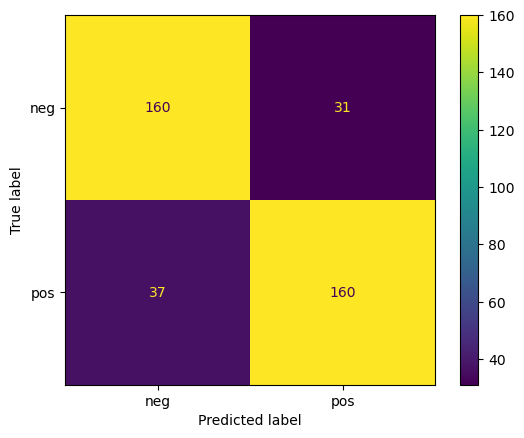

In [56]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

---